In [2]:
import os
import re
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import xml.etree.ElementTree as ET
import json
import numpy as np
from xmltodict import parse
from collections import ChainMap

In [7]:
#'2022-02260 Requester Copy.xml' is from the FOIA request
raw_data = pd.read_xml('2022-02260 Requester Copy.xml',encoding='latin1')
chains = pd.read_csv('dinesafe 2019-04-08 chains.csv', encoding='latin-1', dtype={'Establishment ID':'int','Inspection ID':'int','Company/Franchise':'str','Name':'str','Type':'str','Address':'str','Lat':'float','Long':'float','Status':'str','Minimum inspections per year':'int','Infraction details':'str','Inspection date':'str','Severity':'str','Action':'str','Court outcome':'str','Amount fined':'float'})

In [13]:
len(raw_data['ESTABLISHMENT_ID'].unique())

36378

In [112]:
data = raw_data.fillna(0) #fill in NA values
data['INSPECTION_DATE']=pd.to_datetime(data['INSPECTION_DATE'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733495 entries, 0 to 733494
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ROW_ID                       733495 non-null  int64         
 1   ESTABLISHMENT_ID             733495 non-null  int64         
 2   INSPECTION_ID                733495 non-null  int64         
 3   ESTABLISHMENT_NAME           733495 non-null  object        
 4   ESTABLISHMENTTYPE            733495 non-null  object        
 5   ESTABLISHMENT_ADDRESS        733495 non-null  object        
 6   LATITUDE                     733495 non-null  float64       
 7   LONGITUDE                    733495 non-null  float64       
 8   ESTABLISHMENT_STATUS         733495 non-null  object        
 9   MINIMUM_INSPECTIONS_PERYEAR  733495 non-null  float64       
 10  INFRACTION_DETAILS           733495 non-null  object        
 11  INSPECTION_DATE           

In [113]:
first_insp = data.groupby('ESTABLISHMENT_ID')['INSPECTION_DATE'].min()
last_insp = data.groupby('ESTABLISHMENT_ID')['INSPECTION_DATE'].max()
#how many unique entities are there?
last_insp.count()

36378

<AxesSubplot:xlabel='INSPECTION_DATE', ylabel='Count'>

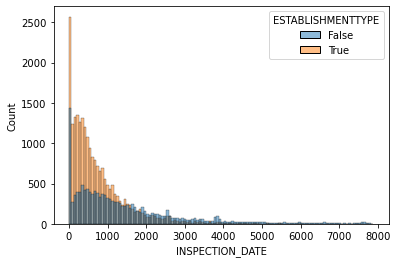

In [139]:
#plot of days between inspections
id_date_group = data.groupby(['ESTABLISHMENT_ID','INSPECTION_DATE'])
id_group = data.groupby(['ESTABLISHMENT_ID'])
#id_date_group['INSPECTION_DATE'].count().unique() #wow, who had 28 inspections?
#sns.histplot(id_date_group['DATE'].count()) #vast majority have only 1-2 inspections
date_range = id_group['INSPECTION_DATE'].max() - id_group['INSPECTION_DATE'].min()
days_per_insp = date_range/id_date_group['INSPECTION_DATE'].count()//pd.Timedelta('1 days') #average days between inspections
day_insp_type = pd.concat([(id_group['ESTABLISHMENTTYPE'].first().str.contains('Take out|Restaurant',case=False)),days_per_insp.groupby('ESTABLISHMENT_ID').min()],axis='columns')
sns.histplot(day_insp_type,x='INSPECTION_DATE',hue='ESTABLISHMENTTYPE')

In [125]:
#how many had their last inspection within a year?
(last_insp>pd.to_datetime('2021-12-31',yearfirst=True)).sum()

14460

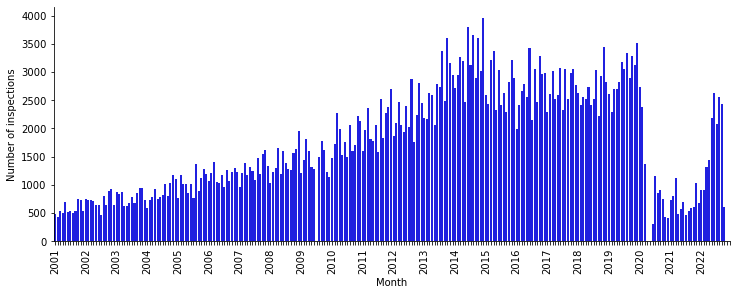

In [126]:
#plot inspections per month
unique_inspections=id_date_group.first()
monthly_inspections = unique_inspections.resample('M',origin='2017-01-01',level='INSPECTION_DATE').count()
monthly_inspections.sum()
inspections_frequency = sns.catplot(data=monthly_inspections.reset_index(),x='INSPECTION_DATE',y='ESTABLISHMENT_NAME',kind='bar',height=4,aspect=3,color='blue')
inspections_frequency.set(xlabel='Month',ylabel='Number of inspections',xticks=range(264))
for ax in inspections_frequency.axes.flat:
    labels = ax.get_xticklabels()
    labels_f = []
    month = 0
    for label in labels:
        if month %12 == 0:
            labels_f.append(pd.to_datetime(label.get_text()).strftime('%Y'))
        else: labels_f.append('')
        month += 1
    ax.set_xticklabels(labels_f, rotation=90) 

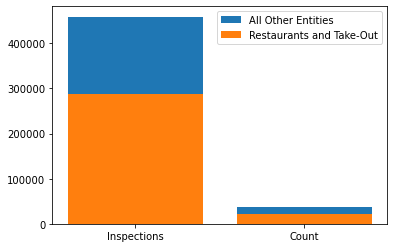

In [137]:
#count inspections for actual restaurants and takeout
is_restaurant = id_group.first()['ESTABLISHMENTTYPE'].str.contains('Food Take Out|Restaurant')
resto_unique_inspections = unique_inspections.join(is_restaurant,rsuffix='.resto')
resto_unique_inspections = resto_unique_inspections.loc[resto_unique_inspections['ESTABLISHMENTTYPE.resto']==True,:]
#resto_unique_inspections.info()
#this one does it proportionally
#restaurant_types = pd.DataFrame([[resto_unique_inspections['INSPECTION_ID'].count()/unique_inspections['INSPECTION_ID'].count(),unique_inspections['INSPECTION_ID'].count()/unique_inspections['INSPECTION_ID'].count()],
#                                 [is_restaurant.sum()/last_insp.count(),last_insp.count()/last_insp.count()]],columns=['Restaurants and Take-out','All Entities'],index=['Inspections','Count'])
restaurant_types = pd.DataFrame([[resto_unique_inspections['INSPECTION_ID'].count(),unique_inspections['INSPECTION_ID'].count()],[is_restaurant.sum(),last_insp.count()]],columns=['Restaurants and Take-out','All Entities'],index=['Inspections','Count'])
plt.figure(figsize=(6,4))
dinesafe_composition = plt.bar(restaurant_types.index,restaurant_types.iloc[:,1])
plt.bar(restaurant_types.index,restaurant_types.iloc[:,0])
plt.legend(['All Other Entities','Restaurants and Take-Out'])

In [142]:
resto_unique_inspections.loc[resto_unique_inspections['ESTABLISHMENT_NAME'].str.contains('4c bro',case=False)==True,:]

ROW_ID  INSPECTION_ID  \
ESTABLISHMENT_ID INSPECTION_DATE                          
10433183         2012-05-22       521423      102751839   
                 2012-10-23       521426      102845990   
                 2013-04-24       521431      102973502   
                 2013-09-05       521433      103080253   
                 2014-02-21       521441      103180618   
                 2014-09-26       521444      103364824   
                 2015-06-08       521446      103508460   
                 2015-11-23       521450      103614242   
                 2015-11-24       521456      103614438   
                 2016-04-26       521457      103716261   
                 2016-10-26       521460      103838523   
                 2017-05-31       521464      103976122   
                 2017-12-21       521466      104091313   
                 2018-04-04       521467      104189590   
                 2018-04-05       521474      104189700   
                 2018-08-28       521477      104292402   
                 2018-08-30       521488      104292505   
                 2018-10-16       521489      104359884   
                 2019-03-01       521494      104419598   
                 2019-07-29       521499      104529715   
                 2019-08-07       521506      104530297   
                 2019-08-13       521508      104536998   
                 2019-11-07       521509      104604334   
                 2021-02-23       521513      104808464   
                 2021-03-15       521518      104808774   
                 2021-11-23       521519      104912103   
                 2021-11-26       521524      104912111   
                 2022-07-06       521526      104990557   
10544572         2015-06-29       637422      103584795   
                 2016-11-30       637429      103858782   
                 2017-06-22       637430      103997275   
                 2017-11-29       637431      104101602   
                 2018-01-30       637432      104141328   
                 2020-12-11       637434      104786183   
10711089         2020-08-10       724699      104732390   
                 2021-01-12       724700      104794326   
                 2022-05-25       724701      104986775   

                                                        ESTABLISHMENT_NAME  \
ESTABLISHMENT_ID INSPECTION_DATE                                             
10433183         2012-05-22                              4C BROAST CHICKEN   
                 2012-10-23                              4C BROAST CHICKEN   
                 2013-04-24                              4C BROAST CHICKEN   
                 2013-09-05                              4C BROAST CHICKEN   
                 2014-02-21                              4C BROAST CHICKEN   
                 2014-09-26                              4C BROAST CHICKEN   
                 2015-06-08                              4C BROAST CHICKEN   
                 2015-11-23                              4C BROAST CHICKEN   
                 2015-11-24                              4C BROAST CHICKEN   
                 2016-04-26                              4C BROAST CHICKEN   
                 2016-10-26                              4C BROAST CHICKEN   
                 2017-05-31                              4C BROAST CHICKEN   
                 2017-12-21                              4C BROAST CHICKEN   
                 2018-04-04                              4C BROAST CHICKEN   
                 2018-04-05                              4C BROAST CHICKEN   
                 2018-08-28                              4C BROAST CHICKEN   
                 2018-08-30                              4C BROAST CHICKEN   
                 2018-10-16                              4C BROAST CHICKEN   
                 2019-03-01                              4C BROAST CHICKEN   
                 2019-07-29                              4C BROAST CHICKEN   
                

In [151]:
#how can we tell which restaurants have gone out of business?
#easy way: use status= out of business
#another way: use last inspection was before 2020
#another way: another restaurant has replaced it at the same address
out_of_business = resto_unique_inspections.loc[resto_unique_inspections['ESTABLISHMENT_STATUS'].str.contains('out of business',case=False)==True,:]
out_of_business.index.unique() #11058 entries
out_of_business.reset_index(level=1).index.unique #11058 entries
#same length, so there are no duplicates here - restaurants don't go out of business twice

<bound method Index.unique of Int64Index([ 1223438,  9000002,  9000029,  9000109,  9000145,  9000214,
             9000228,  9000265,  9000278,  9000286,
            ...
            10759065, 10759069, 10759216, 10759697, 10761364, 10761648,
            10761653, 10762366, 10764681, 10765468],
           dtype='int64', name='ESTABLISHMENT_ID', length=11058)>

<AxesSubplot:xlabel='INSPECTION_DATE.last', ylabel='Count'>

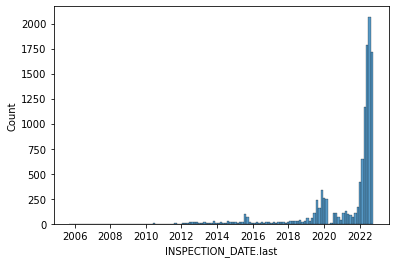

In [175]:
#now see the last inspections of restaurants are that still in business
unique_resto = id_group.last().loc[is_restaurant.loc[is_restaurant==True].index]
active_resto = unique_resto.drop(out_of_business.reset_index(level=1).index)
active_resto_last = active_resto.join(last_insp,rsuffix='.last')
sns.histplot(active_resto_last,x='INSPECTION_DATE.last')

0 inspected before 2019, 10402 inspected during and after 2019


<AxesSubplot:xlabel='INSPECTION_DATE.last', ylabel='Count'>

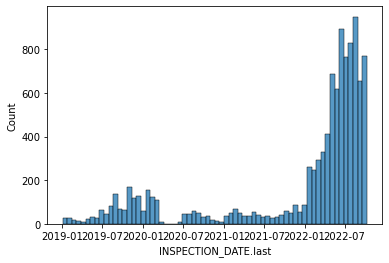

In [203]:
#the majority were last inspected in 2022, but a number still haven't been inspected starting in 2019
#so let's just assume that anything last inspected before 2019 has gone out of business
before_2019 = active_resto_last['INSPECTION_DATE.last']<pd.to_datetime('2019-01-01')
print('{} inspected before 2019, {} inspected during and after 2019'.format(before_2019.sum(),active_resto_last['INSPECTION_DATE.last'].count()-before_2019.sum()))
#add these businesses to the out-of-business list
out_of_business = pd.concat([out_of_business.reset_index()['ESTABLISHMENT_ID'],before_2019.loc[before_2019==True].reset_index()['ESTABLISHMENT_ID']]).reset_index(drop=True)
#and check the remainder
active_resto = unique_resto.drop(out_of_business)
active_resto_last = active_resto.join(last_insp,rsuffix='.last')
sns.histplot(active_resto_last,x='INSPECTION_DATE.last')

In [306]:
#great, now see if anything on the remaining active restaurant list has been replaced
#we want to check if the following conditions are true:
#1: another restaurant is at the same address
#2: it is not part of a food court
#3: the second restaurant has its first inspection after the first restaurant has its last inspection

#let's start with #1: check if the address is shared
shared_or_replaced = active_resto.groupby('ESTABLISHMENT_ADDRESS').count()
shared_or_replaced = shared_or_replaced.loc[shared_or_replaced['ESTABLISHMENT_NAME']>1] #about 1100 restaurants
#now check #2: 
#let's assume that if the address was shared in 2017 and 2018, then it is a food court. this might include very high turnover locations
#shared addresses in 2017
food_courts_2017 = resto_unique_inspections.reset_index(level=1)
food_courts_2017 = food_courts_2017.loc[(food_courts_2017['INSPECTION_DATE']<pd.to_datetime('2018-01-01')) & (food_courts_2017['INSPECTION_DATE']>=pd.to_datetime('2017-01-01'))]
food_courts_2017 = food_courts_2017.groupby('ESTABLISHMENT_ADDRESS').count()
food_courts_2017 = food_courts_2017.loc[food_courts_2017['ESTABLISHMENT_NAME']>1]
#shared addresses in 2018
food_courts_2018 = resto_unique_inspections.reset_index(level=1)
food_courts_2018 = food_courts_2018.loc[(food_courts_2018['INSPECTION_DATE']<pd.to_datetime('2019-01-01')) & (food_courts_2018['INSPECTION_DATE']>=pd.to_datetime('2018-01-01'))]
food_courts_2018 = food_courts_2018.groupby('ESTABLISHMENT_ADDRESS').count()
food_courts_2018 = food_courts_2018.loc[food_courts_2018['ESTABLISHMENT_NAME']>1]
#shared addresses in both years
food_courts = food_courts_2018.loc[food_courts_2018.index.isin(food_courts_2017.index)]
#drop addresses from food courts
shared = shared_or_replaced.index.isin(food_courts.index)
replaced = shared_or_replaced.loc[~shared] #220 rows

#now we have a list of restaurants that may have been replaced
#let's drop anything with more than two restaurants registered at the address, because a random validation indicates that they are new food courts
replaced = replaced.loc[replaced['ROW_ID']<3]

#let's now tackle #3: first inspection and last inspection do not overlap
overlap_resto = active_resto.join(replaced,on='ESTABLISHMENT_ADDRESS',how='right',rsuffix='.r')
#add column showing ID of restaurant sharing the location with them
overlap_resto = pd.concat([overlap_resto.reset_index().groupby('ESTABLISHMENT_ADDRESS').first()['ESTABLISHMENT_ID'].rename('first'),
                           overlap_resto.reset_index().groupby('ESTABLISHMENT_ADDRESS').last()['ESTABLISHMENT_ID'].rename('last')],axis='columns')
overlap_resto = pd.concat([overlap_resto.join(first_insp,on='first',rsuffix='.first').rename(columns={'INSPECTION_DATE':'first_insp1'}),
                           overlap_resto.join(last_insp,on='first',rsuffix='.first').rename(columns={'INSPECTION_DATE':'first_insp2'})['first_insp2'],
                           overlap_resto.join(first_insp,on='last',rsuffix='.first').rename(columns={'INSPECTION_DATE':'last_insp1'})['last_insp1'],
                           overlap_resto.join(last_insp,on='last',rsuffix='.first').rename(columns={'INSPECTION_DATE':'last_insp2'})['last_insp2']],axis='columns')
#find non-overlapping restaurants:
replaced = overlap_resto.loc[overlap_resto['last_insp1']>overlap_resto['first_insp2']]
replaced['first'] #71 replaced

ESTABLISHMENT_ADDRESS
1006 DUNDAS ST W        10671237
1010 WILSON AVE         10727501
1086 ISLINGTON AVE      10677030
1120 MARTIN GROVE RD    10274551
124 BELFIELD RD          9003274
                          ...   
78 GERRARD ST W         10724171
799 BRIMLEY RD          10518927
852 WILSON AVE          10537577
881 ST CLAIR AVE W      10635548
971 KINGSTON RD         10406629
Name: first, Length: 71, dtype: int64

In [310]:
out_of_business = pd.concat([out_of_business,replaced['first']]).reset_index(drop=True)
#great, so now we have a list of dead restaurants about 16,000 long
#let's plot their lifespans: time between first and last inspection

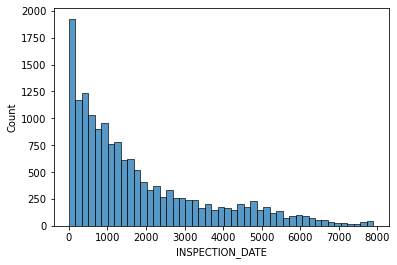

In [406]:
lifespans_dead = last_insp[out_of_business]-first_insp[out_of_business]
#don't forget that currently-alive restaurants have a lifespan as well, this is just a list of dead restaurants
#have to convert it to days otherwise run out of memory trying to hist nanoseconds
lifespans_dead_plot = sns.histplot(lifespans_dead.dt.days)
#okay, but this is a histogram of lifespans, we need to convert it to a cumulative survival curve
#day 0 is the sum of all restaurants with lifespan >0, day 1000 is the sum of all restaurants with lifespan > 1000, etc
survival_curve = []
for x in range(8000): 
    survival_curve.append([x,lifespans_dead.loc[lifespans_dead.dt.days>x].count()])
survival_curve = pd.DataFrame(survival_curve)

0.8537976782752902

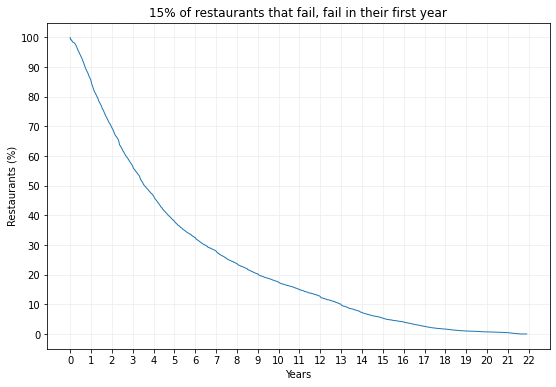

In [474]:
survival_curve = survival_curve.rename({0:'Days',1:'Restaurants'},axis='columns')
fig, survival_plot = plt.subplots(figsize=(9,6))
survival_plot.set(xlabel='Years',ylabel='Restaurants (%)',title='15% of restaurants that fail, fail in their first year',xticks=range(23),yticks=np.multiply(range(11),10))
survival_plot.plot(survival_curve['Days']/365.25,survival_curve['Restaurants']/survival_curve['Restaurants'].max()*100,linewidth=1.0)
survival_plot.grid(color='#eeeeee')
survival_curve.loc[365,'Restaurants']/survival_curve['Restaurants'].max()

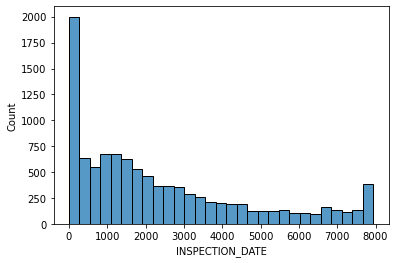

In [531]:
#how long have currently-alive restaurants lasted for?
out_of_business = out_of_business.rename('out_of_business')
is_restaurant.loc[is_restaurant==True].reset_index()['ESTABLISHMENT_ID'].isin(out_of_business.rename('out_of_business'))
#12120 True... but should be 16159
out_of_business.isin(is_restaurant.index).sum() #16159 as expected
in_business = is_restaurant.loc[is_restaurant==True]
in_business = in_business.drop(out_of_business) #22451->10331 after drop, losing 12120 businesses. not 16159.
#so what is not being counted?
out_of_business.duplicated().sum() #4039 are duplicated, explaining the discrepancy
lifespans_alive = last_insp[in_business.index]-first_insp[in_business.index]
#don't forget that currently-alive restaurants have a lifespan as well, this is just a list of dead restaurants
#have to convert it to days otherwise run out of memory trying to hist nanoseconds
lifespans_alive_plot = sns.histplot(lifespans_alive.dt.days)

0.9108330515161763

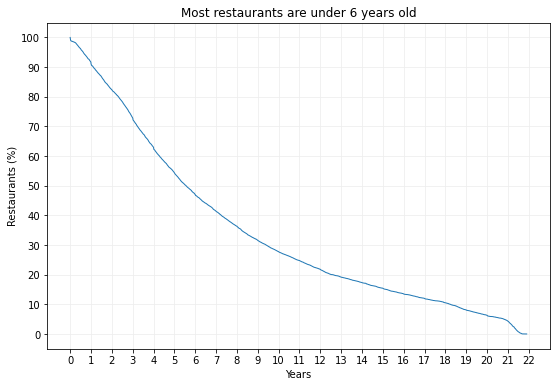

In [544]:
#so some have lasted the whole length of the dataset - still alive!
#let's add them to the survival curve
#plot the number of active restaurants by age to determine our cutoff for long-term survivors
age_curve = []
for x in range(8000): 
    age_curve.append([x,lifespans_alive.loc[lifespans_alive.dt.days>x].count()])
age_curve = pd.DataFrame(age_curve)
age_curve = age_curve.rename({0:'Days',1:'Restaurants'},axis='columns')
fig, age_plot = plt.subplots(figsize=(9,6))
age_plot.set(xlabel='Years',ylabel='Restaurants (%)',title='Most restaurants are under 6 years old',xticks=range(23),yticks=np.multiply(range(11),10))
age_plot.plot(age_curve['Days']/365.25,age_curve['Restaurants']/age_curve['Restaurants'].max()*100,linewidth=1.0)
age_plot.grid(color='#eeeeee')
age_curve.loc[365,'Restaurants']/age_curve['Restaurants'].max()

In [547]:
#so the bend seems to be at 21 years = 7665 days
age_curve.loc[365*21,'Restaurants']
#there are 388 restaurants that have survived up to 21 years - so add that as the base of the survival curve

388

0.8323740541938822

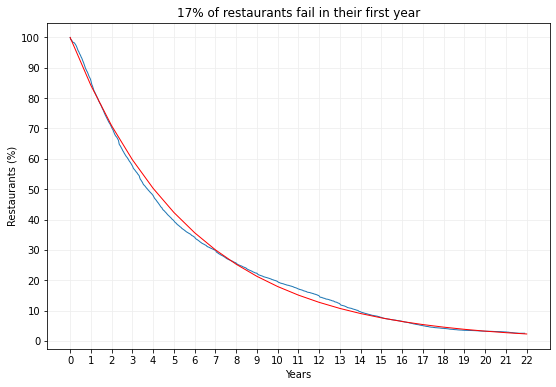

In [576]:
survival_curve = survival_curve.rename({0:'Days',1:'Restaurants'},axis='columns')
fig, survival_plot2 = plt.subplots(figsize=(9,6))
#title: 17% of restaurants fail in their first year
#title: Age doesn\'t matter much: chances of failure remain constant
survival_plot2.set(xlabel='Years',ylabel='Restaurants (%)',title='',xticks=range(23),yticks=np.multiply(range(11),10))
survival_plot2.plot(survival_curve['Days']/365.25,
                    (survival_curve['Restaurants']+age_curve.loc[365*21,'Restaurants'])
                    /(survival_curve['Restaurants'].max()+age_curve.loc[365*21,'Restaurants'])*100,
                    linewidth=1.0)
#let's try to fit a decay constant:
test_decay = []
half_life = 0.172
for x in range(23):
    test_decay.append(100*np.e ** (-x*half_life))
survival_plot2.plot(test_decay,color='red',linewidth=1.0)

survival_plot2.grid(color='#eeeeee')
survival_curve.loc[365,'Restaurants']/(survival_curve['Restaurants'].max()+age_curve.loc[365*21,'Restaurants'])

In [557]:
survival_curve.loc[survival_curve['Restaurants']>=(survival_curve.iloc[0,1]+age_curve.loc[365*21,'Restaurants'])/2,'Days'].max()
#the median lifetime of a restaurant is 3.5 years

1262

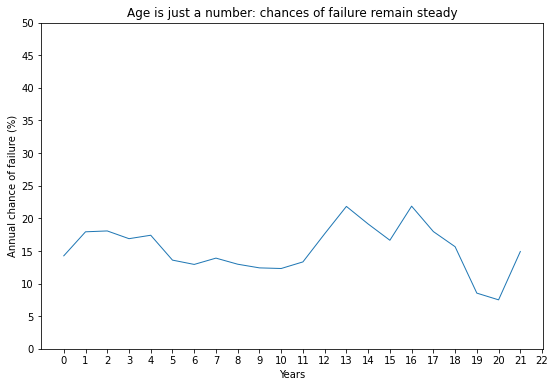

In [644]:
#plot chances of failure by age
yearly_survival=pd.DataFrame()
for x in range(23): 
    yearly_survival = pd.concat([yearly_survival,survival_curve.loc[survival_curve.loc[survival_curve['Days']<=(365*x)]['Days'].max()]])
yearly_survival = pd.concat([yearly_survival.reset_index().loc[yearly_survival.reset_index()['index']=='Days',0].reset_index(drop=True),
                             yearly_survival.reset_index().loc[yearly_survival.reset_index()['index']=='Restaurants',0].reset_index(drop=True)], axis='columns',ignore_index=True)
yearly_survival[1]=yearly_survival[1]+age_curve.loc[365*21,'Restaurants']
failure_rate=[]
for x in range(yearly_survival.shape[0]-1):
    failure_rate.append(100*(1-yearly_survival.iloc[x+1,1]/yearly_survival.iloc[x,1]))
fig, annual_failure_plot = plt.subplots(figsize=(9,6))
#title: Age is just a number: chances of failure remain steady
annual_failure_plot.set(xlabel='Years',ylabel='Annual chance of failure (%)',title='Age is just a number: chances of failure remain steady',xticks=range(23),ylim=(0,25),yticks=np.multiply(range(11),5))
annual_failure_plot.plot(failure_rate, linewidth=1.0)